In [48]:
import pandas as pd
import numpy as np

In [49]:
import scipy.stats as stat
import matplotlib.pyplot as plt

In [50]:
import scipy.optimize as optimize
import scipy.special as sp

In [51]:
df = pd.read_csv('../Data_All_180906/CSV/Forecasting AI Progress v1.0.csv')

In [52]:
df = df.iloc[:,9:]

In [53]:
df.columns = ['name','surname','employer','job','Q1',
             'Q2','Q3','Q4','Q5a','Q5b','Q5c','Cq5','Q6a','Q6b',
             'Q6c','Cq6','Q7a','Q7b','Q7c','Q8a','Q8b','Q8c',
             'Cq7-8','Q9a','Q9b','Q9c','Q10a','Q10b','Q10c',
             'Cq9-10','Q11','Q12','Q13','Cq11-13']

In [54]:
df = df.dropna(subset=['name','surname','employer','job'])

In [55]:
print(df.shape)

(201, 34)


In [56]:
q1 = df.Q1
q2 = df.Q2
q3 = df.Q3
q4 = df.Q4
q5 = df[['Q5a','Q5b','Q5c']]
q6 = df[['Q6a','Q6b','Q6c']]
q7 = df[['Q7a','Q7b','Q7c']]
q8 = df[['Q8a','Q8b','Q8c']]
q9 = df[['Q9a','Q9b','Q9c']]
q10 = df[['Q10a','Q10b','Q10c']]
q11 = df.Q11
q12 = df.Q12
q13 = df.Q13

In [57]:
q1 = q1.dropna()
q2 = q2.dropna()
q3 = q3.dropna()
q4 = q4.dropna()
q5 = q5.dropna()
q6 = q6.dropna()
q7 = q7.dropna()
q8 = q8.dropna()
q9 = q9.dropna()
q10 = q10.dropna()
q11 = q11.dropna()
q12 = q12.dropna()
q13 = q13.dropna()

In [58]:
q11.shape

(165,)

# Questions 11 & 12

In [59]:
q11_ = df[['Q11',"Q12"]]
q11_ = q11_.iloc[1:]
print(q11_.shape)
q11_ = q11_.dropna()
print(q11_.shape)
q11_.Q11 = pd.to_numeric(q11_.Q11)
q11_.Q12 = pd.to_numeric(q11_.Q12)
q11_ = q11_[q11_.Q11 >= 0.000001]
q11_ = q11_[q11_.Q11 <= 100.]
q11_ = q11_[q11_.Q12 >= 0.000001]
q11_ = q11_[q11_.Q12 <= 100.]
q11_ = q11_[q11_.Q11-q11_.Q12 >= 0.000001]
ydata = np.array([5.,10.])#,0.])
xdata = np.asarray(q11_)
print(xdata[:5])
x,y = xdata.shape
xdata_ = .99999999*np.ones((x,y+1))
for i in range(xdata.shape[0]):
    for j in range(xdata.shape[1]):
        xdat = xdata[i,j]
        xdat = float(xdat)*0.01
        xdata_[i,j+1] = xdat
'''
xdata_ = np.zeros((x,y))
for i in range(xdata.shape[0]):
    for j in range(xdata.shape[1]):
        xdat = xdata[i,j]
        xdat = float(xdat)*0.01
        xdata_[i,j] = xdat'''
xdata = xdata_

(200, 2)
(164, 2)
[[98 89]
 [76 61]
 [96 95]
 [95 75]
 [35 15]]


In [60]:
ydata = np.asarray([0.,5.,10.])

### Fitting to Gamma CDF 

In [61]:
def ff(params,xdata,ydata):
    return xdata-params[1]*sp.gammaincinv(float(params[0]),ydata.astype(float))

In [62]:
x0f = np.array([9.,1.])

In [63]:
print(ydata)
print(xdata[0])

[ 0.  5. 10.]
[0.99999999 0.98       0.89      ]


In [64]:
xdata = 1-xdata

In [65]:
paramsf = optimize.least_squares(ff, x0f, args=(ydata,xdata[0]),max_nfev=10000,
                                tr_solver='exact')
dataxx = stat.gamma.rvs(paramsf.x[0], 0., scale=paramsf.x[1], size=100)
datayy = stat.gamma.cdf(dataxx,paramsf.x[0], 0., scale=paramsf.x[1])
ct=1
for i in range(1,q11_.shape[0]):
    try:
        paramsf = optimize.least_squares(ff, x0f, args=(ydata, xdata[i]),max_nfev=10000,
                                tr_solver='exact')
    except: 
        print(xdata[i])
        continue
    dataxx = np.concatenate((dataxx,stat.gamma.rvs(paramsf.x[0], 0., scale=paramsf.x[1], size=100)),axis=0)
    datayy = np.concatenate((datayy,stat.gamma.cdf(dataxx[ct*100:],paramsf.x[0], 0., scale=paramsf.x[1])),axis=0)
    cdf = stat.gamma.cdf(dataxx[ct*100:],paramsf.x[0], 0., scale=paramsf.x[1])
    xdat = dataxx[ct*100:]
    ct += 1
    if ct%20 == 0:
        print(ct)
print(ct)

20
40
60
80
100
117


In [66]:
datayy -= 0.000000000001

In [67]:
for i in range(datayy.shape[0]):
    if datayy[i] < 0:
        datayy[i] = 0.0000000001
        dataxx[i] = 0.0000000001

In [68]:
for i in range(dataxx.shape[0]):
    if dataxx[i] > 100.:
        dataxx[i] = 100.

In [69]:
paramsxx = optimize.least_squares(ff, x0f, args=(dataxx[:], datayy[:]),max_nfev=10000,
                                tr_solver='exact')

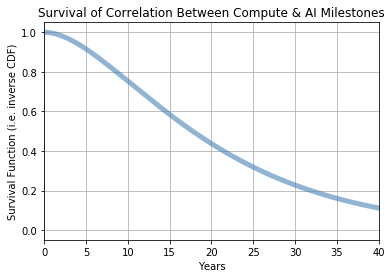

In [70]:
dataxx.sort()
plt.plot(dataxx,stat.gamma.sf(dataxx, paramsxx.x[0],0.,paramsxx.x[1]),'steelblue',lw=5,alpha=0.6)
plt.xlim(0,40)
plt.grid()
plt.xlabel('Years')
plt.ylabel('Survival Function (i.e. inverse CDF)')
plt.title('Survival of Correlation Between Compute & AI Milestones')
plt.savefig('compute-trend-survival.png')
plt.show()

In [71]:
print(1-xdata[:,0].mean())
print(1-np.median(xdata[:,0]))

0.99999999
0.99999999


In [72]:
print(1-xdata[:,1].mean())
print(1-np.median(xdata[:,1]))

0.6494017094017095
0.7000000000000001


In [73]:
print(1-xdata[:,2].mean())
print(1-np.median(xdata[:,2]))

0.46589743589743593
0.5


# Question 13

In [74]:
q13 = df['Q13']

In [75]:
q13.dropna()
counts = q13.value_counts()

In [76]:
print(counts)

50%                   35
100%                  34
400% or greater       31
25%                   23
200%                  19
It would slow down    12
0%                    10
Response               1
Name: Q13, dtype: int64


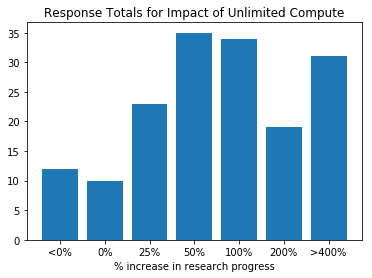

In [77]:
fig, ax = plt.subplots()
idx = ['','<0%','0%','25%','50%','100%','200%','>400%']
idn = [0,1,2,3,4,5,6]
counts2 = [counts[5],counts[6],counts[3],counts[0],counts[1],counts[4],counts[2]]
plt.bar(idn,counts2[:7])
ax.set_xticklabels(idx)
plt.title('Response Totals for Impact of Unlimited Compute')
plt.xlabel('% increase in research progress')
plt.savefig('unlimited-compute.png')
plt.show()